In [1]:
#code of Interactive Quantum Classifier Inspired by Quantum Open System Theory
#LINK https://ieeexplore.ieee.org/document/9533917

#LINK https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=9533917

#this code was written by Fernando Maciano de Paula Neto (fernando@cin.ufpe.br) together with Eduardo Barreto Brito (ebb2@cin.ufpe.br)

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cityblock
from helpers.icq_methods import create_and_execute_classifier

In [3]:
VARY_INPUT = "input"
VARY_BOTH = "both"
DIFFERENT_VARIATIONS = [VARY_INPUT, VARY_BOTH]

In [4]:
def classical_neuron_output_func(i_n, w_n):
    x = np.dot(i_n, w_n)
    activation = 1 / (1 + np.exp(-x))
    return np.round(activation), activation

In [5]:
def generate_many_points(n_points, scale=1, varied_part=VARY_INPUT, output_func=create_and_execute_classifier):
  np.random.seed(1000)
  list_of_x = []
  list_of_y = []
  list_of_z = []
  
  for i in range(n_points):
    # We need to study what happens when we variate different things
    if varied_part == VARY_INPUT:
      i_n = scale*np.random.uniform(low=-1, high=1, size=(1,))
      w_n = np.ones((1,))
    elif varied_part == VARY_BOTH:
      i_n = scale*np.random.uniform(low=-1, high=1, size=(1,))
      w_n = scale*np.random.uniform(low=-1, high=1, size=(1,))
    
    z,p_cog = output_func(i_n, w_n)
    list_of_x.append(i_n[0])
    list_of_y.append(p_cog.real)
    list_of_z.append(z)

  return list_of_x, list_of_y, list_of_z

In [6]:
def plot_graph(list_of_x, list_of_y):
    plt.plot(list_of_x, list_of_y, color="red", marker="o",  linestyle="")
    ax = plt.gca()
    ax.tick_params(axis='y', colors='red')
    ax.tick_params(axis='x', colors='red')
    
    ax.set_xlabel("Input")
    ax.xaxis.label.set_color('red')

    ax.set_ylabel("Activation")
    ax.yaxis.label.set_color('red')
    
    plt.xticks(np.arange(-4, 4, 1))
    plt.yticks(np.arange(0, 1, 0.1))
    plt.show()

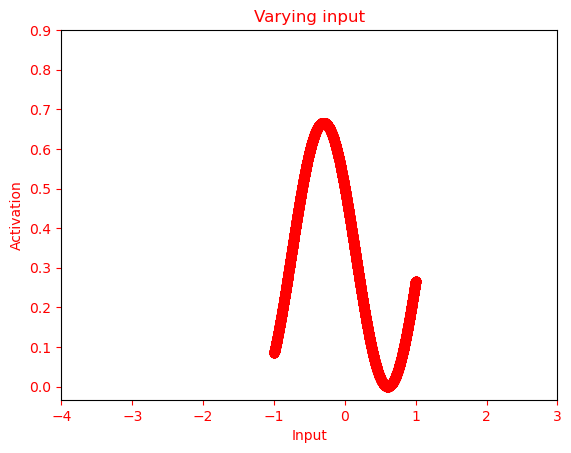

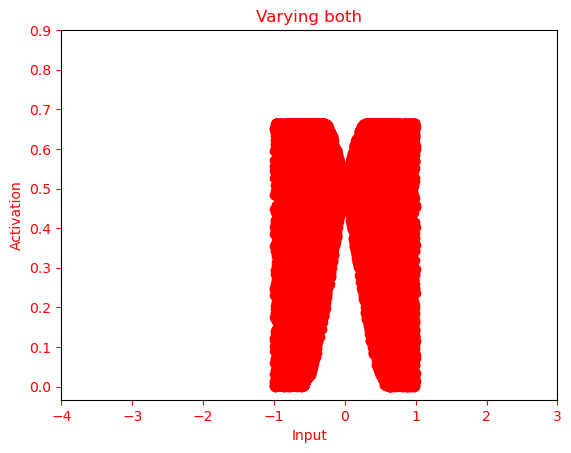

In [7]:
# First let's see only what happens when we change what we're trying to vary
for variation in DIFFERENT_VARIATIONS:
    list_of_x, list_of_y, list_of_z = generate_many_points(10000, varied_part=variation)
    plt.title("Varying " + variation, color = "red")
    plot_graph(list_of_x, list_of_y)

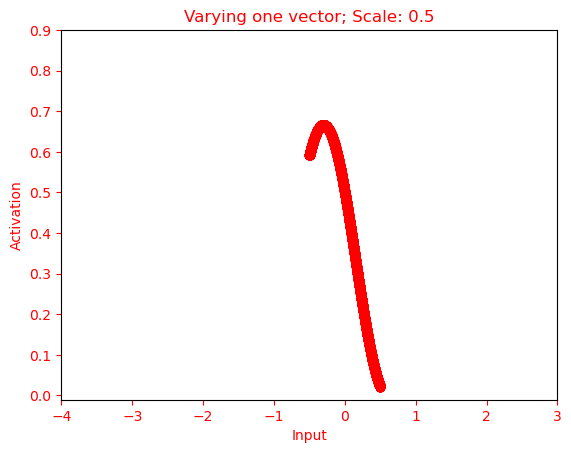

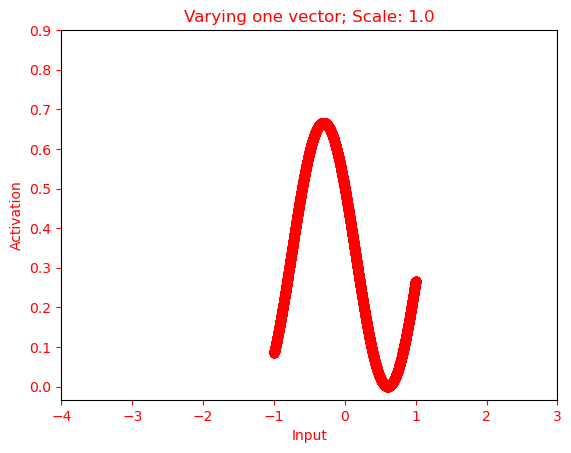

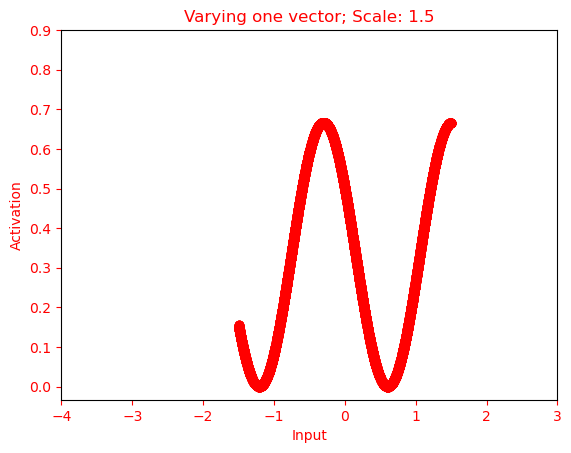

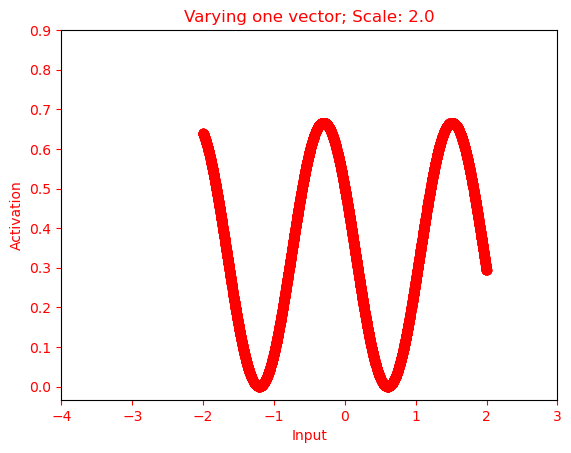

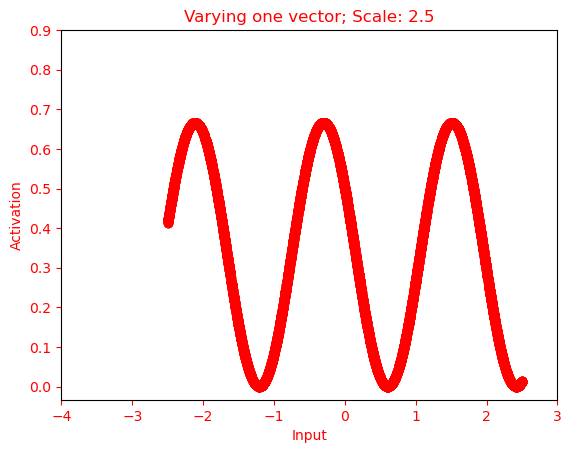

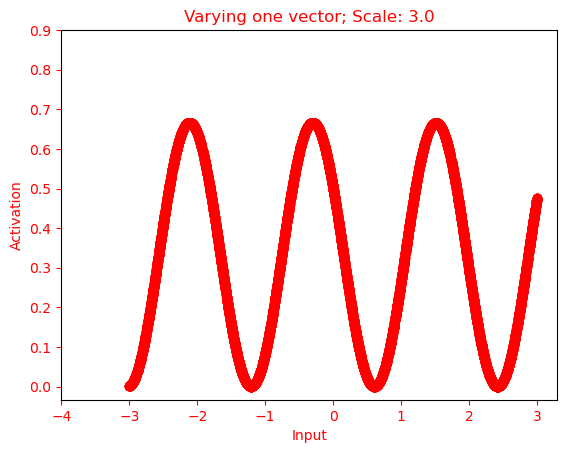

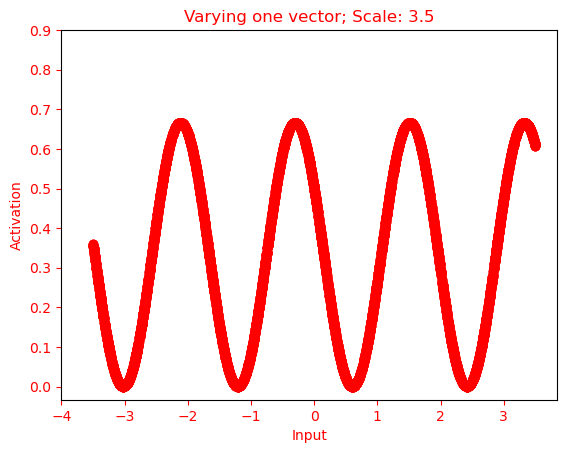

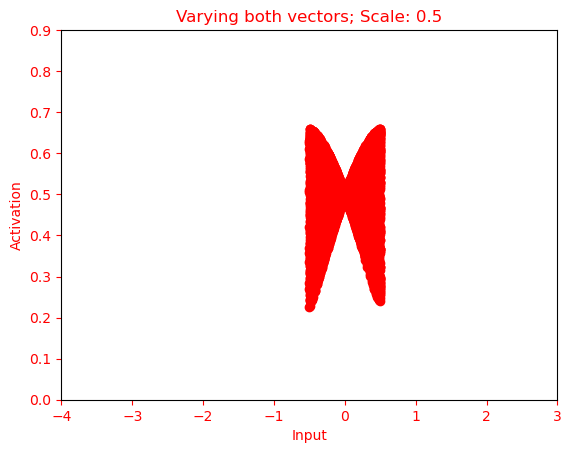

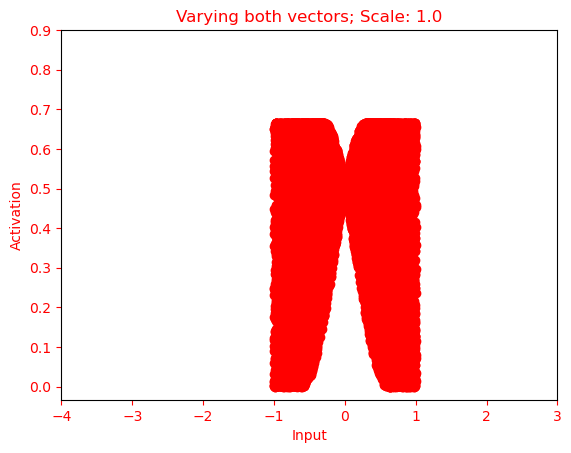

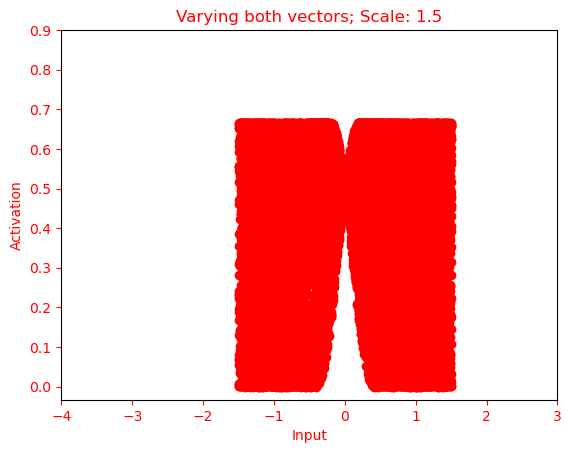

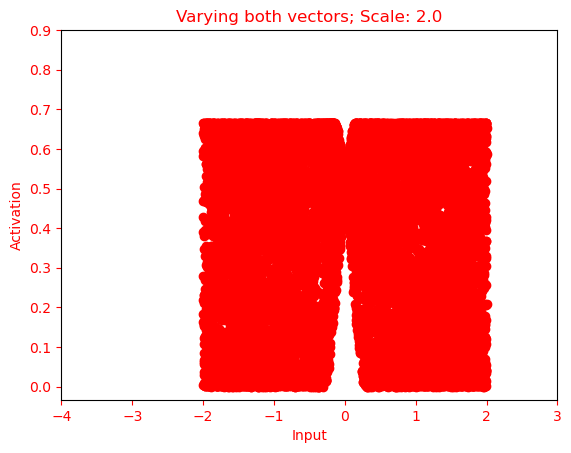

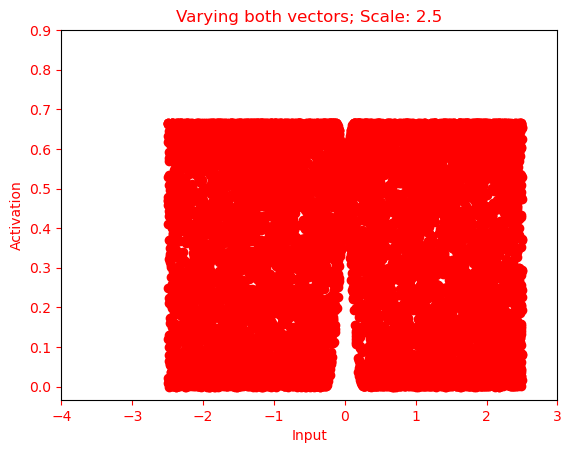

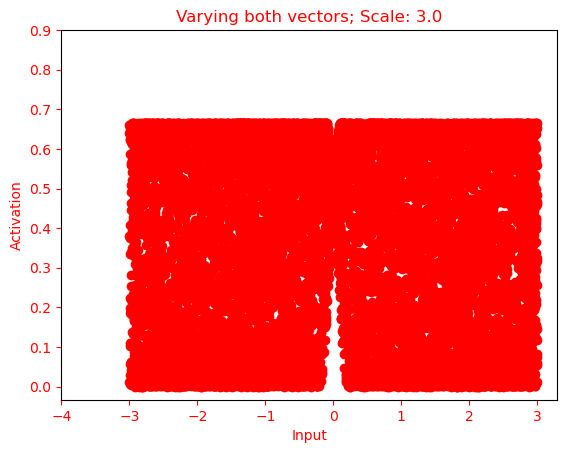

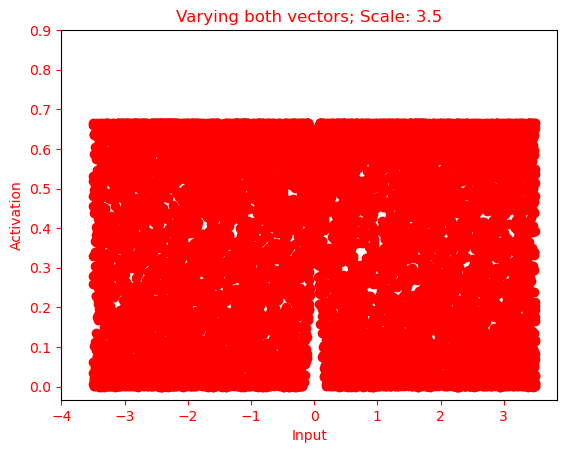

In [8]:
for variation in [VARY_INPUT, VARY_BOTH]:
    for n in np.arange(0.5, 4, 0.5):
        if variation == VARY_INPUT:
            vary = 'one vector'
        else:
            vary = 'both vectors'
        list_of_x, list_of_y, list_of_z = generate_many_points(10000, scale=n, varied_part=variation)
        plt.title("Varying " + vary + "; Scale: " + str(n), color = "red")
        plot_graph(list_of_x, list_of_y)

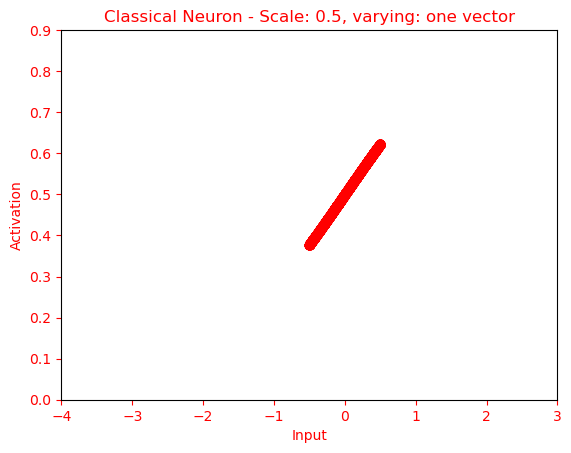

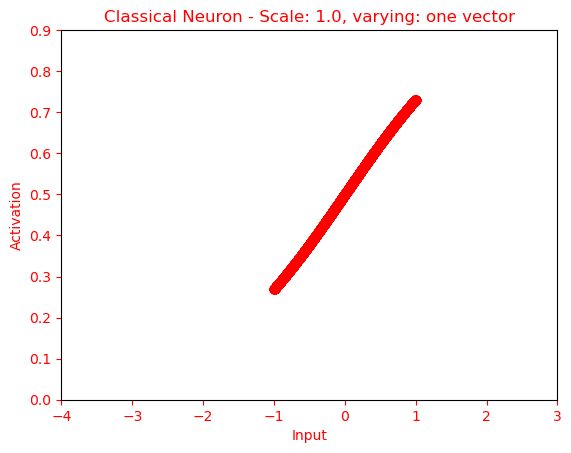

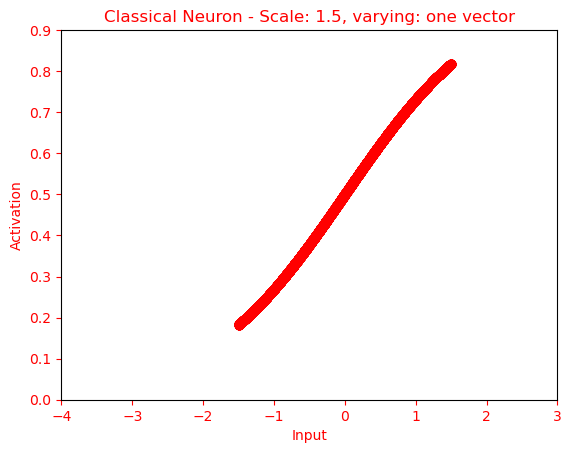

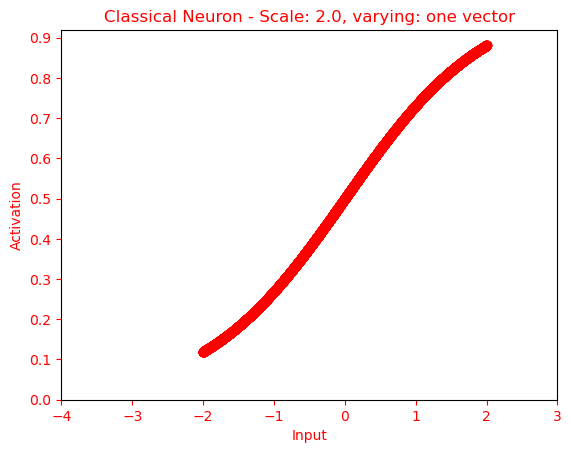

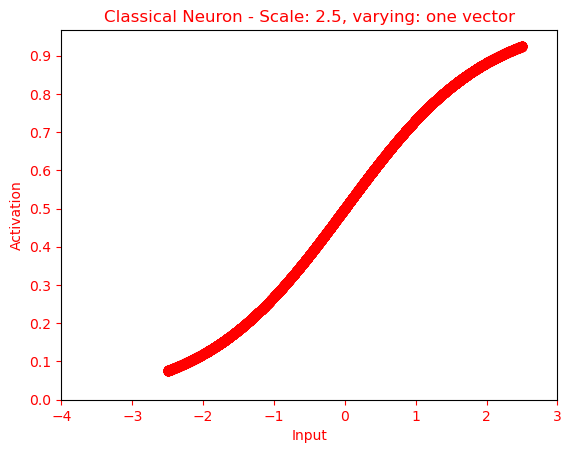

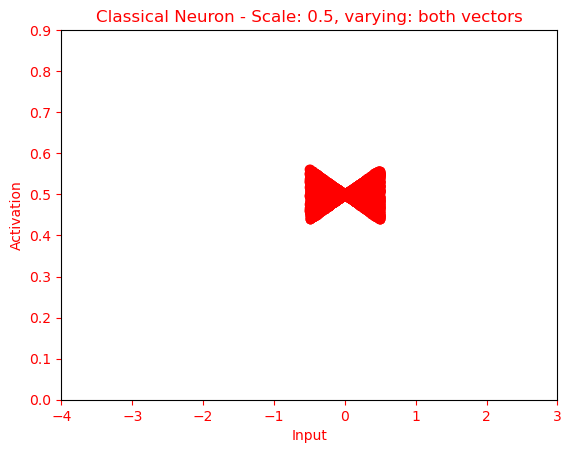

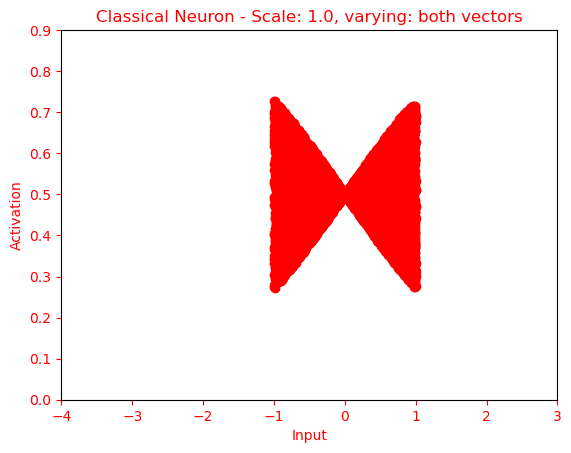

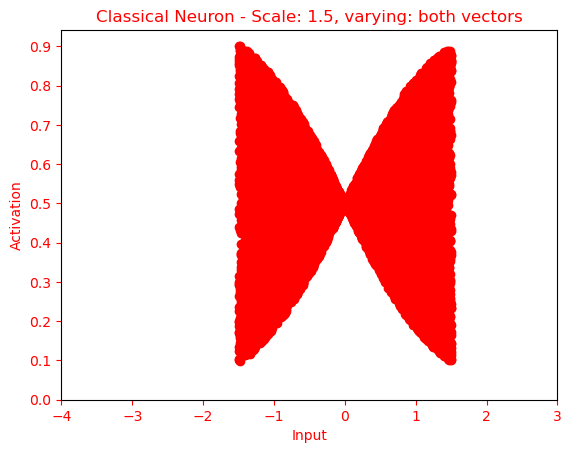

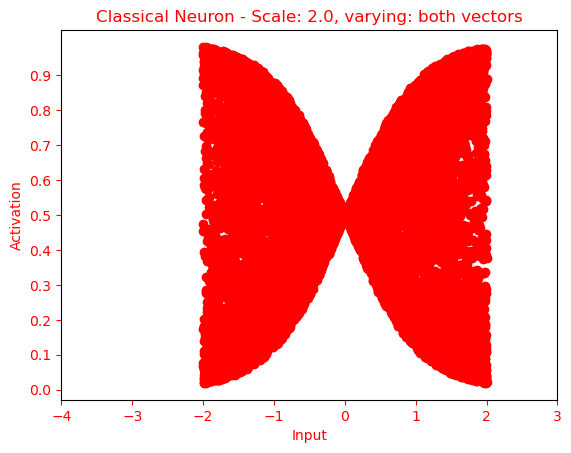

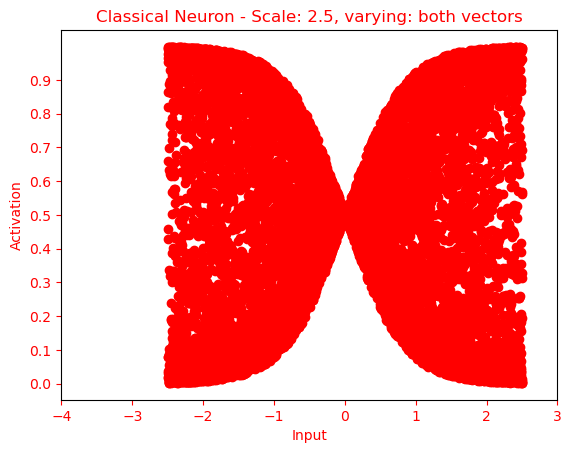

In [9]:
for variation in [VARY_INPUT, VARY_BOTH]:
    for n in np.arange(0.5, 3, 0.5):
        if variation == VARY_INPUT:
            vary = 'one vector'
        else:
            vary = 'both vectors'
        list_of_x, list_of_y, list_of_z = generate_many_points(10000, scale=n, varied_part=variation, output_func=classical_neuron_output_func)
        plt.title("Classical Neuron - " + "Scale: " + str(n) + ", varying: " + vary, color = "red")
        plot_graph(list_of_x, list_of_y)

In [10]:
import sympy
from sympy.abc import x, y, z, w
from sympy import Matrix, exp, simplify, Trace
from sympy.physics.quantum.trace import Tr
from sympy.physics.quantum.dagger import Dagger
from sympy.physics.quantum import TensorProduct

In [13]:
def calculated_fun(i_n, w_n):
    sigma_q_sympy = Matrix([
        [1, (1 - 1j)],
        [(1j + 1), -1]
    ])
    sigma_e_sympy = Matrix([[i_n[0] * w_n[0]]])
    sigma_e_sigma_q = 1j*TensorProduct(sigma_q_sympy, sigma_e_sympy)
    
    # TensorProduct = Kroenecker product: https://docs.sympy.org/latest/modules/physics/quantum/tensorproduct.html
    # exp = matrix exponential https://stackoverflow.com/questions/47240208/sympy-symbolic-matrix-exponential
    u_operator_sympy = Matrix(sigma_e_sigma_q).exp()
    
    p_cog = Matrix([
        [1/2,1/2],
        [1/2,1/2]
        ])
    p_env = Matrix([
        [1]
    ])
    quantum_operation_sympy = u_operator_sympy * TensorProduct(p_cog, p_env) * Dagger(u_operator_sympy)
    p_cog_00 = complex(quantum_operation_sympy.evalf()[0,0])
    p_cog_11 = complex(quantum_operation_sympy.evalf()[1,1])
    
    p_cog_00 = np.real(p_cog_00)
    p_cog_11 = np.real(p_cog_11)

    if (p_cog_00 >= p_cog_11):
        z = 0
    else:
        z = 1
    return z, p_cog_11

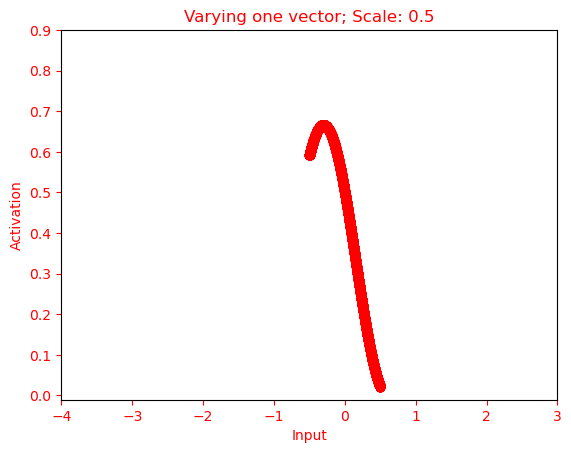

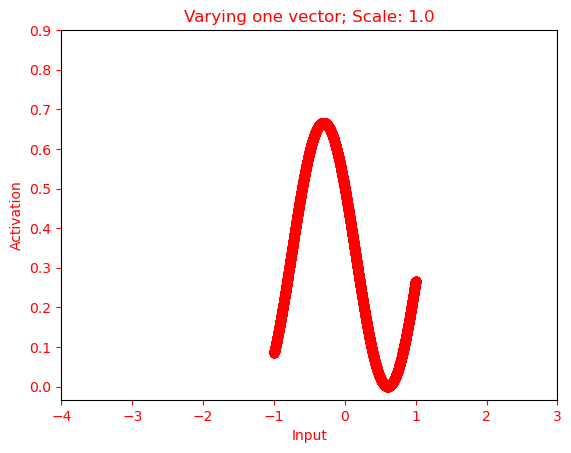

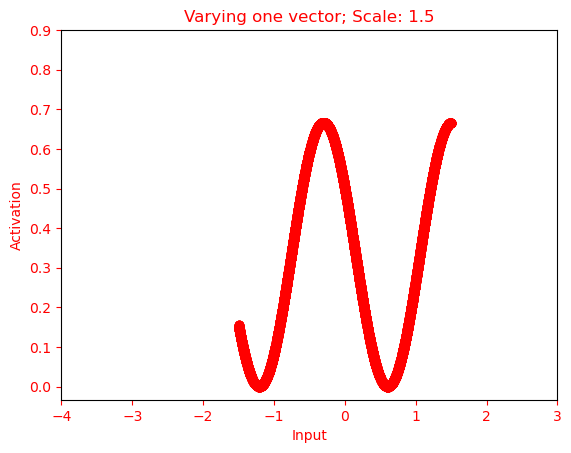

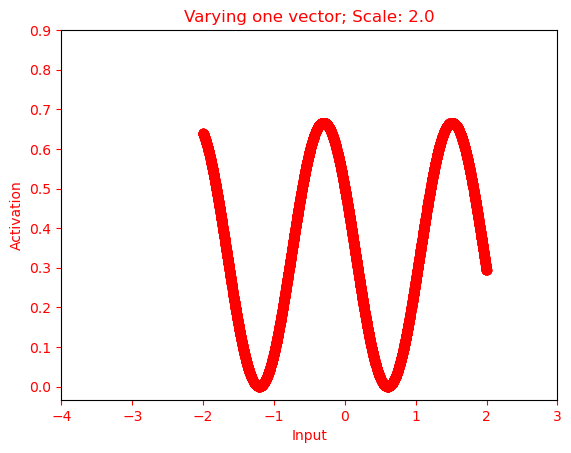

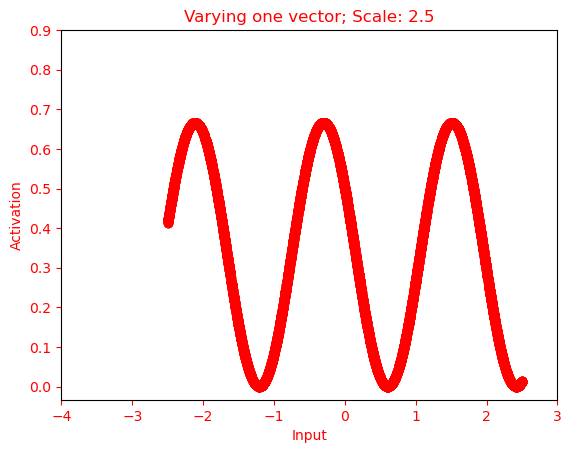

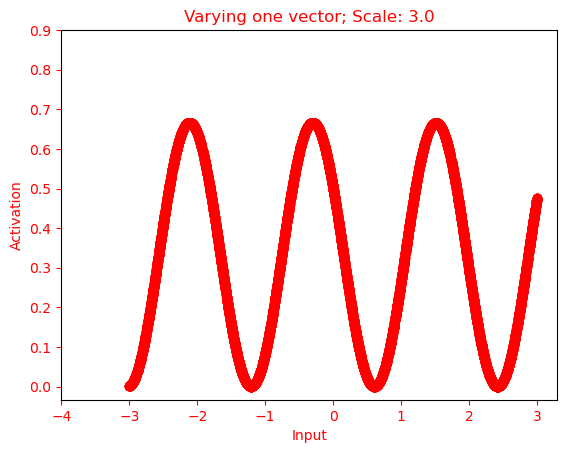

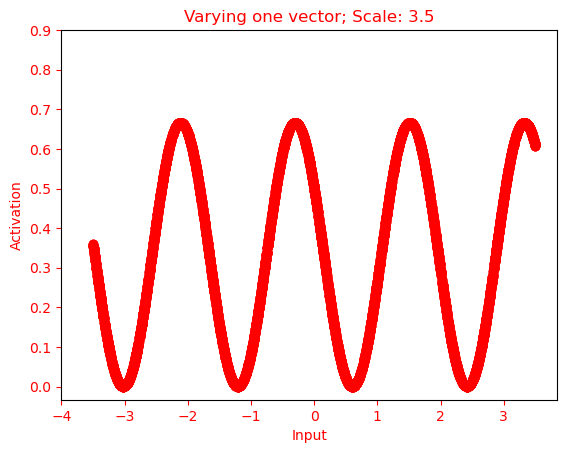

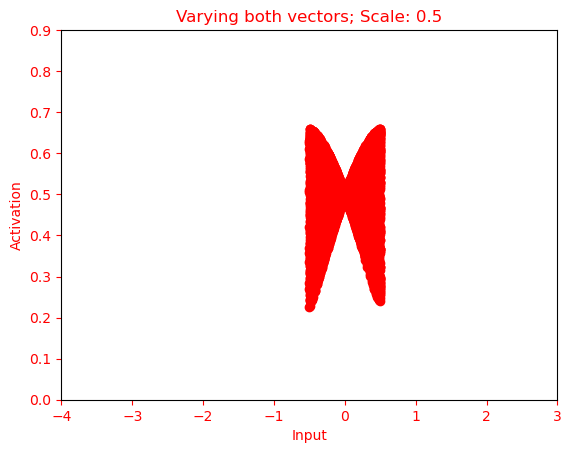

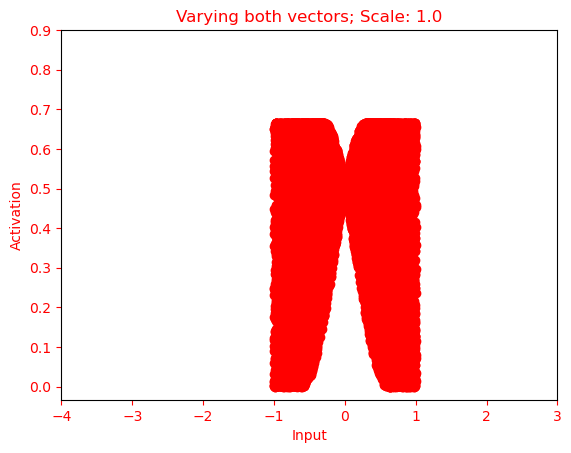

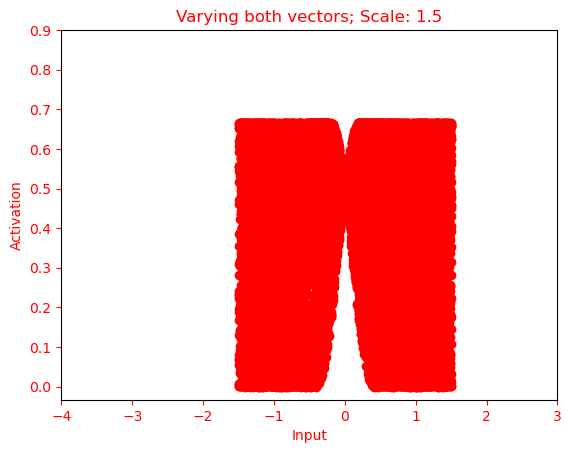

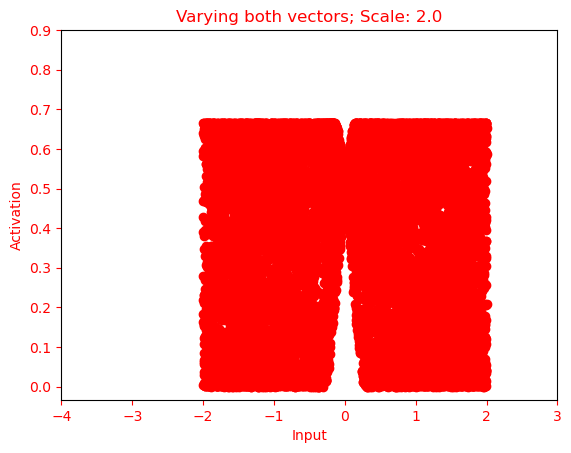

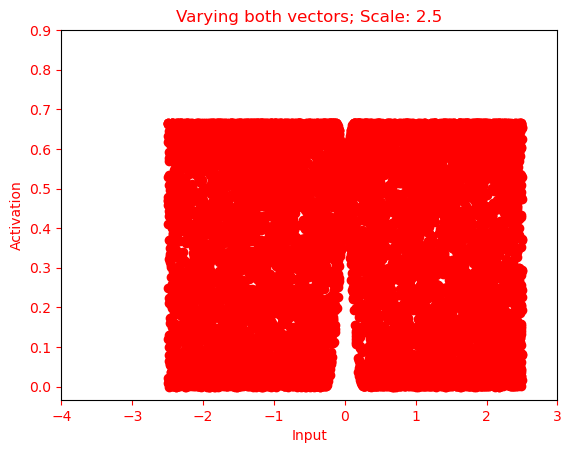

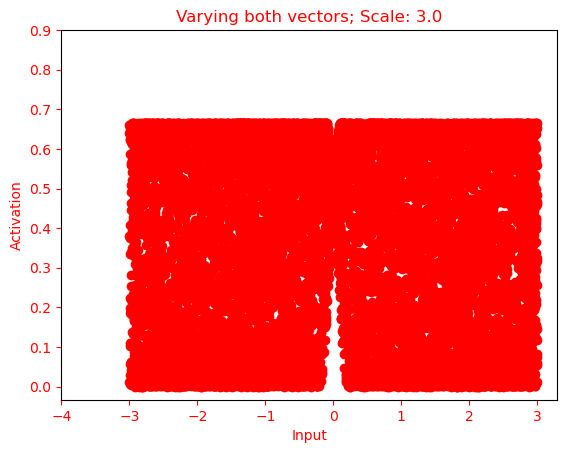

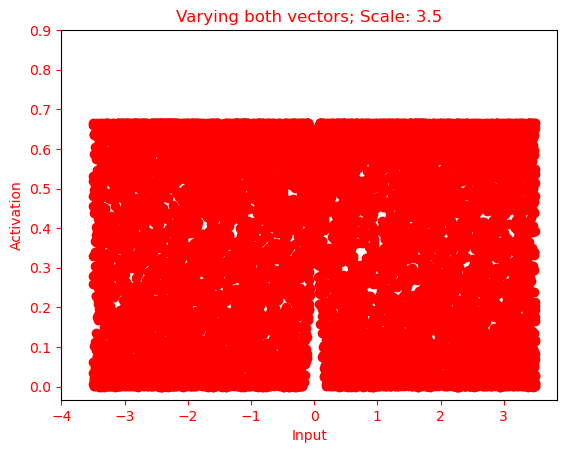

In [14]:
for variation in [VARY_INPUT, VARY_BOTH]:
    for n in np.arange(0.5, 4, 0.5):
        if variation == VARY_INPUT:
            vary = 'one vector'
        else:
            vary = 'both vectors'
        list_of_x, list_of_y, list_of_z = generate_many_points(10000, scale=n, varied_part=variation, output_func=calculated_fun)
        plt.title("Varying " + vary + "; Scale: " + str(n), color = "red")
        plot_graph(list_of_x, list_of_y)